<a href="https://colab.research.google.com/github/carlogalli/colab-gpu/blob/main/jmp_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU).

In [1]:
VERSION   # print Julia version

v"1.7.2"

In [102]:
using Pkg
Pkg.add(["CUDA", "Random", "Distributions", "Printf", "BenchmarkTools", "PyPlot", "PrettyTables", "PyCall"]);
#Pkg.add(["CUDA", "Random", "Distributions", "Printf", "BenchmarkTools", "PrettyTables"]);
ENV["JULIA_CUDA_USE_BINARYBUILDER"] = false
using Random, Distributions, CUDA, Printf, BenchmarkTools, PyPlot, PrettyTables, PyCall;
#using Random, Distributions, CUDA, Printf, BenchmarkTools, PrettyTables;

function print_gpu_properties()

    for (i,device) in enumerate(CUDA.devices())
        println("*** General properties for device $i ***")
        name = CUDA.name(device)
        println("Device name: $name")
        major = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR)
        minor = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR)
        println("Compute capabilities: $major.$minor")
        clock_rate = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_CLOCK_RATE)
        println("Clock rate: $clock_rate")
        device_overlap = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_GPU_OVERLAP)
        print("Device copy overlap: ")
        println(device_overlap > 0 ? "enabled" : "disabled")
        kernel_exec_timeout = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_KERNEL_EXEC_TIMEOUT)
        print("Kernel execution timeout: ")
        println(kernel_exec_timeout > 0 ? "enabled" : "disabled")
        # a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X)
        # d = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X)       
        a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT)
        println("Number of multiprocessors: $a")
        b = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCKS_PER_MULTIPROCESSOR)
        println("Max blocks per MP: $b")
        c = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)        
        println("Max threads per block: $c")
        
        println([a b c a*b*c])
    end
end
print_gpu_properties()
# with the falseENV option it takes 117.357304 seconds (35.94 M allocations: 2.301 GiB, 1.29% gc time, 11.71% compilation time)
# without the falseENV option it takes  124.465413 seconds (39.74 M allocations: 2.537 GiB, 1.27% gc time, 12.65% compilation time)


#Pkg.add("CpuId")
#using CpuId
#cpuinfo()

*** General properties for device 1 ***
Device name: Tesla T4
Compute capabilities: 7.5
Clock rate: 1590000
Device copy overlap: enabled
Kernel execution timeout: disabled
Number of multiprocessors: 40
Max blocks per MP: 16
Max threads per block: 1024
Int32[40 16 1024 655360]


   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [438e738f] + PyCall v1.94.1
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


# JMP functions

In [153]:
CUDA.allowscalar(false)

struct Model_GPU
    # Model Parameters
    β::Float32      # df govt
    β_hh::Float32   # df hh
    σ::Float32      # risk aversion
    α_m::Float32    # MIU scaling factor
    η::Float32      # MIU curvature
    γ::Float32      # govt spending utility curvature
    g_lb::Float32   # govt spending lower bound
    α_g::Float32    # govt spending weight
    r::Float32      # intnl risk-free rate
    ρ::Float32      # income process persistence
    σ_ϵ::Float32    # income process error standard deviation
    θ::Float32      # ree-enter probability
    h::Float32      # haircut on debt
    d0::Float32     # linear coefficient on default costadd C
    d1::Float32     # quadratic coefficient on default cost
    ρ_B::Float32    # coefficient of Gumbel debt taste shocks
    ρ_μ::Float32    # coefficient of Gumbel mu_D taste shocks
    ρ_δ::Float32    # coefficient of Gumbel enforcement shocks
    λ::Float32      # debt maturity
    κ::Float32      # debt coupon

    ny::Int32
    nB::Int32
    T_longterm::Int32
    T_sim::Int32
    T_discard_sim::Int32

    Bgrid_lb::Float32
    Bgrid_ub::Float32
end

function Model_GPU(;
    β=.83, β_hh=.99, σ=2., α_m=2e-5, η=3., γ=2., g_lb=0., α_g=0.074, r=0.00598,
    ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, d0=-0.4, d1=0.44, 
    ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3, λ=0.0465, κ=0.,
    ny=51, nB=150, T_longterm=20, T_sim=10^3, T_discard_sim=100, Bgrid_lb=1e-2, Bgrid_ub=2.5
    )

    N = ny*nB

    return Model_GPU(β, β_hh, σ, α_m, η, γ, g_lb, α_g, r, ρ, σ_ϵ, θ, h, d0, d1, ρ_B, ρ_μ, ρ_δ, λ, κ, ny, nB, T_longterm, T_sim, T_discard_sim, Bgrid_lb, Bgrid_ub)
end

function tauchen_carlo(N::Int32, ρ::Float32, σ_ϵ::Float32; μ::Real=0, n_std::Real=4)

    # process (x_t above) standard deviation (std is ϵ's standard deviation)
    σ_y = σ_ϵ/sqrt(1-ρ^2)
    grid_bar = n_std * σ_y      # grid bounds
    grid = collect(Float32, range(μ-grid_bar, stop=μ+grid_bar, length=N))
    dif = grid[2]-grid[1]
  
    # Get transition probabilities
    P = zeros(Float32, N, N)
    
    # return nothing

    for row in 1:N
        
        # do endpoints first
        P[row, 1] = cdf(Normal(0., 1.), (grid[1]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        P[row, N] = 1-cdf(Normal(0., 1.), (grid[N]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )

        # middle columns
        for col in 2:N-1
            P[row, col] = cdf(Normal(0., 1.), (grid[col]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ ) - cdf(Normal(0., 1.), (grid[col]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        end
    end

    # normalize
    sums = sum(P, dims=2)    

    P = @. P/sums
    
    if maximum(abs.(sum(P, dims=2).-1)) > 1e-6
        error("Matrix rows must sum up to 1!")
    end
  
    return grid, P
end

function ydef_fn(m::Model_GPU, y::Float32)
    return y - max(0, m.d0*y + m.d1*y^2)
end

function my_dot_product(xvec, yvec)
    temp = Float32(0)
    for i in 1:lastindex(xvec)
        temp += xvec[i]*yvec[i]
    end
    return temp
end

function my_brent(
    f::Function , x_lower::Float32, x_upper::Float32;
    rel_tol::Float32 = sqrt(eps(Float32)),
    abs_tol::Float32 = eps(Float32),
    iterations::Int32 = Int32(1000),
    my_trace::Bool = false)


    if x_lower > x_upper
        error("x_lower must be less than x_upper")
    end

    golden_ratio = Float32(1)/2 * (3 - sqrt(Float32(5.0)))

    new_minimizer = x_lower + golden_ratio*(x_upper-x_lower)
    new_minimum = f(new_minimizer)
    best_bound = "initial"
    f_calls = 1 # Number of calls to f
    step = zero(Float32)
    old_step = zero(Float32)

    old_minimizer = new_minimizer
    old_old_minimizer = new_minimizer

    old_minimum = new_minimum
    old_old_minimum = new_minimum

    iteration = 0
    converged = false
    stopped_by_callback = false

    while iteration < iterations && !stopped_by_callback

        p = zero(Float32)
        q = zero(Float32)

        x_tol = rel_tol * abs(new_minimizer) + abs_tol

        x_midpoint = (x_upper+x_lower)/2

        if abs(new_minimizer - x_midpoint) <= 2*x_tol - (x_upper-x_lower)/2
            converged = true
            break
        end

        iteration += 1

        if abs(old_step) > x_tol
            # Compute parabola interpolation
            # new_minimizer + p/q is the optimum of the parabola
            # Also, q is guaranteed to be positive

            r = (new_minimizer - old_minimizer) * (new_minimum - old_old_minimum)
            q = (new_minimizer - old_old_minimizer) * (new_minimum - old_minimum)
            p = (new_minimizer - old_old_minimizer) * q - (new_minimizer - old_minimizer) * r
            q = 2(q - r)

            if q > 0
                p = -p
            else
                q = -q
            end
        end

        if abs(p) < abs(q*old_step/2) && p < q*(x_upper-new_minimizer) && p < q*(new_minimizer-x_lower)
            old_step = step
            step = p/q

            # The function must not be evaluated too close to x_upper or x_lower
            x_temp = new_minimizer + step
            if ((x_temp - x_lower) < 2*x_tol || (x_upper - x_temp) < 2*x_tol)
                step = (new_minimizer < x_midpoint) ? x_tol : -x_tol
            end
        else
            old_step = (new_minimizer < x_midpoint) ? x_upper - new_minimizer : x_lower - new_minimizer
            step = golden_ratio * old_step
        end

        # The function must not be evaluated too close to new_minimizer
        if abs(step) >= x_tol
            new_x = new_minimizer + step
        else
            new_x = new_minimizer + ((step > 0) ? x_tol : -x_tol)
        end

        new_f = f(new_x)
        f_calls += 1

        if new_f < new_minimum
            if new_x < new_minimizer
                x_upper = new_minimizer
                best_bound = "upper"
            else
                x_lower = new_minimizer
                best_bound = "lower"
            end
            old_old_minimizer = old_minimizer
            old_old_minimum = old_minimum
            old_minimizer = new_minimizer
            old_minimum = new_minimum
            new_minimizer = new_x
            new_minimum = new_f
        else
            if new_x < new_minimizer
                x_lower = new_x
            else
                x_upper = new_x
            end
            if new_f <= old_minimum || old_minimizer == new_minimizer
                old_old_minimizer = old_minimizer
                old_old_minimum = old_minimum
                old_minimizer = new_x
                old_minimum = new_f
            elseif new_f <= old_old_minimum || old_old_minimizer == new_minimizer || old_old_minimizer == old_minimizer
                old_old_minimizer = new_x
                old_old_minimum = new_f
            end
        end
    end

    if my_trace
        out = iteration, iteration == iterations, converged, rel_tol, abs_tol, f_calls
        return new_minimizer, new_minimum, out
    else
        return new_minimizer, new_minimum
    end
end

function model_init!(m, grids, arrays_rep, arrays_def)
    Bgrid, ygrid, ~ = grids
    vr, c_rep, rb_rep, Bprime_rep, ~, ~, q_rep = arrays_rep
    vd, c_def, rb_def, Bprime_def, μ_def, ~, q_def, ~ = arrays_def

    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    # tid_x, tid_y, bid_x, bid_y = threadIdx().x, threadIdx().y, blockIdx().x, blockIdx().y
    # @cuprintln("y0 $y0, B0 $B0, tid_x $tid_x, tid_y $tid_y, bid_x $bid_x, bid_y $bid_y")

    if B0 <= lastindex(Bgrid) && y0 <= lastindex(ygrid)
        #= Repayment: in the last period, max U(c,rb,g) s.t. c=y-̃B*rb =#
        rb_rep[B0,y0] = 0.5 * ygrid[y0]/Bgrid[B0]
        c_rep[B0,y0] = ygrid[y0]-Bgrid[B0]*rb_rep[B0,y0]
        vr[B0,y0] = (c_rep[B0,y0]^(1-m.σ))/(1-m.σ) + m.α_m*(rb_rep[B0,y0]^(1-m.η))/(1-m.η)
        Bprime_rep[B0,y0] = 0.
        q_rep[B0, y0] = 1.
        
        #= Default: in the last period, max U(c,rb,g) s.t. c=y_def-̃B*(1-h)*rb =#
        yd = ydef_fn(m,ygrid[y0])
        rb_def[B0,y0] = 0.5*yd/(Bgrid[B0]*(1-m.h))
        c_def[B0,y0] = yd-Bgrid[B0]*(1-m.h)*rb_def[B0,y0]
        vd[B0,y0] = (c_def[B0,y0]^(1-m.σ))/(1-m.σ) + m.α_m*(rb_def[B0,y0]^(1-m.η))/(1-m.η)
        # vd[B0,y0] = U_fn(m, c_def[B0,y0], rb_def[B0,y0])
        Bprime_def[B0,y0] = 0.
        μ_def[B0,y0] = 0.
        q_def[B0, y0] = 1.
    end

    return nothing
end

"""
    update_values_expectations_1!()
    uses: m, vr, vd
    updates: def_policy, v
"""
function update_values_expectations_1!(
        m::Model_GPU, arrays, arrays_rep, arrays_def
    )

    def_policy, v, ~, ~ = arrays
    vr = arrays_rep[1]
    vd = arrays_def[1]

    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B0 <= m.nB && y0 <= m.ny

        # tid_x, tid_y, bid_x, bid_y = threadIdx().x, threadIdx().y, blockIdx().x, blockIdx().y
        # @cuprintln("y0 $y0, B0 $B0, B1_def_hc $B1_def_hc, tid_x $tid_x, tid_y $tid_y, bid_x $bid_x, bid_y $bid_y")

        if exp((vd[B0,y0]-vr[B0,y0])/m.ρ_δ) == Inf
            def_policy[B0,y0] = 1.
        else
            def_policy[B0,y0] = exp((vd[B0,y0]-vr[B0,y0])/m.ρ_δ) / (1+exp((vd[B0,y0]-vr[B0,y0])/m.ρ_δ))
        end    
        v[B0,y0] = def_policy[B0,y0]*vd[B0,y0] + (1-def_policy[B0,y0])*vr[B0,y0]
    end

    return nothing
end

"""
    update_values_expectations_2!()
    uses: m, Bgrid, v, vd, P, def_policy, c_rep, rb_rep, q_rep, c_def, rb_def, q_def
    updates: ev, evd, qtilde_rep, qtilde_def, moneyEulerRHS_rep, moneyEulerRHS_def, bondsEulerRHS_rep, bondsEulerRHS_def
"""
function update_values_expectations_2!(
        m::Model_GPU, grids, arrays, arrays_rep, arrays_def, eulers_rep, eulers_def
    )

    Bgrid, ygrid, P = grids
    def_policy, v, ev, evd = arrays
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep = arrays_rep
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def = arrays_def
    moneyEulerRHS_rep, bondsEulerRHS_rep = eulers_rep
    moneyEulerRHS_def, bondsEulerRHS_def = eulers_def

    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B0 <= lastindex(Bgrid) && y0 <= lastindex(ygrid)

        B1 = B0
        B1_def = B1     # to keep things clearer when computing qtilde_def
        B1_def_hc = CUDA.min(CUDA.searchsortedfirst(Bgrid, Bgrid[B1_def]*(1-m.h)), m.nB)

        # Reset values to zero
        ev[B1, y0], evd[B1, y0] = 0., 0.
        qtilde_rep[B1, y0], qtilde_def[B1, y0] = 0., 0.
        moneyEulerRHS_rep[B1, y0], moneyEulerRHS_def[B1, y0] = 0., 0.
        bondsEulerRHS_rep[B1, y0], bondsEulerRHS_def[B1, y0] = 0., 0.

        for y1 in 1:m.ny

            # compute expected value functions, makes them functions of (̃B',y)
            ev[B1, y0] += v[B1, y1] * P[y0, y1]
            evd[B1, y0] += vd[B1, y1] * P[y0, y1]

            #= 
            the update of the qtilde price fns should only use q_rep and q_def, not qtilde's 
            =#

            # uses: def_policy, q_rep, rb_rep, q_def, rb_def
            qtilde_rep[B1,y0] += (
                (1-def_policy[B1,y1])*(m.λ+(1-m.λ)*(m.κ+q_rep[B1,y1]))*rb_rep[B1,y1] + def_policy[B1,y1]*q_def[B1,y1]*rb_def[B1,y1]
            ) * P[y0,y1]
        
            # uses: q_def, rb_def here, q_rep, rb_rep below
            qtilde_def[B1_def, y0] += (
                (1-m.θ)*q_def[B1_def,y1]*rb_def[B1_def,y1] + 
                m.θ*(
                    (1-def_policy[B1_def_hc,y1])*(m.λ+(1-m.λ)*(m.κ+q_rep[B1_def_hc,y1]))*rb_rep[B1_def_hc,y1] 
                    + def_policy[B1_def_hc,y1]*q_def[B1_def_hc,y1]*rb_def[B1_def_hc,y1]
                )
            ) * P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            moneyEulerRHS_rep[B1, y0] += m.β_hh * (
                    (1-def_policy[B1,y1])*(c_rep[B1,y1]^(-m.σ) + m.α_m*rb_rep[B1,y1]^(-m.η))*rb_rep[B1,y1] + def_policy[B1,y1]*(c_def[B1,y1]^(-m.σ) + m.α_m*rb_def[B1,y1]^(-m.η))*rb_def[B1,y1]
                ) * P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            moneyEulerRHS_def[B1, y0] += m.β_hh * (
                    (1-m.θ)*(c_def[B1,y1]^(-m.σ) + m.α_m*rb_def[B1,y1]^(-m.η))*rb_def[B1,y1] + 
                    m.θ*(1-def_policy[B1_def_hc,y1])*(c_rep[B1_def_hc,y1]^(-m.σ) + m.α_m*rb_rep[B1_def_hc,y1]^(-m.η))*rb_rep[B1_def_hc,y1] + 
                    m.θ*def_policy[B1_def_hc,y1]*(c_def[B1_def_hc,y1]^(-m.σ) + m.α_m*rb_def[B1_def_hc,y1]^(-m.η))*rb_def[B1_def_hc,y1]
                ) * P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            bondsEulerRHS_rep[B1, y0] += m.β_hh * (
                    (1-def_policy[B1,y1])*(c_rep[B1,y1]^(-m.σ))*rb_rep[B1,y1] + 
                    def_policy[B1,y1]*(c_def[B1,y1]^(-m.σ))*rb_def[B1,y1]
                ) * P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            bondsEulerRHS_def[B1, y0] += m.β_hh * (
                    (1-m.θ)*(c_def[B1,y1]^(-m.σ))*rb_def[B1,y1] + 
                    m.θ*(1-def_policy[B1_def_hc,y1])*(c_rep[B1_def_hc,y1]^(-m.σ))*rb_rep[B1_def_hc,y1] + 
                    m.θ*def_policy[B1_def_hc,y1]*(c_def[B1_def_hc,y1]^(-m.σ))*rb_def[B1_def_hc,y1]
                ) * P[y0,y1]
        end
    end

    return nothing
end

function vr_gridsearch(m::Model_GPU, grids, arrays, arrays_rep, eulers_rep, arrays_temp_rep)
    
    #B0s, y0s = tests
    Bgrid, ygrid, P = grids
    def_policy, v, ev, evd = arrays
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep = arrays_rep
    moneyEulerRHS_rep, bondsEulerRHS_rep = eulers_rep
    vs_rep, cs_rep, rbs_rep, cps_rep = arrays_temp_rep
    
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    
    # tid_x, tid_y, bid_x, bid_y = threadIdx().x, threadIdx().y, blockIdx().x, blockIdx().y
    # @cuprintln("y0 $y0, B0 $B0, tid_x $tid_x, tid_y $tid_y, bid_x $bid_x, bid_y $bid_y")
    
    # xstar, fstar = my_brent(x->B0*x^2+y0*x, Float32(-10), Float32(10))
    # vs[B0,y0] = fstar
    # cs[B0,y0] = xstar

    if B0 <= m.nB && y0 <= m.ny

        #y0s[B0,y0]=y0
        #B0s[B0,y0]=B0
        vstar = Float32(-Inf)

        for B1 in 1:m.nB
            c_lb = Float32(1e-4)
            c_ub = ygrid[y0] + qtilde_rep[B1, y0]*Bgrid[B1]

            c, ~ = my_brent(
                        c -> -(c^(1-m.σ))/(1-m.σ) - m.α_m*((
                            (ygrid[y0]+qtilde_rep[B1,y0]*Bgrid[B1]-c)/(Bgrid[B0]*(m.λ+(1-m.λ)*m.κ + qtilde_rep[B1,y0]*(1-m.λ)*c^(-m.σ)/(m.β_hh*moneyEulerRHS_rep[B1, y0])))
                       )^(1-m.η))/(1-m.η), 
                        c_lb, c_ub)
            rb = (ygrid[y0]+qtilde_rep[B1,y0]*Bgrid[B1]-c)/(Bgrid[B0]*(m.λ+(1-m.λ)*m.κ + qtilde_rep[B1,y0]*(1-m.λ)*c^(-m.σ)/(m.β_hh*moneyEulerRHS_rep[B1, y0])))

            cs_rep[B0,y0,B1] = c
            rbs_rep[B0,y0,B1] = rb

            # ucprime = c^(-m.σ)
            # μ = moneyEulerRHS_rep[B1,y0] / (rb * ucprime) - 1
            # μs_rep[B0,y0,B1] = μ
            # qs_rep[B0,y0,B1] = qtilde_rep[B1, y0] / (rb*(1+μ)*(1+m.r))
            # is_rep[B0,y0,B1] = ((1+μ)*rb*ucprime) / bondsEulerRHS_rep[B1, y0]

            v = (c^(1-m.σ))/(1-m.σ) + m.α_m*(rb^(1-m.η))/(1-m.η) + m.β * ev[B1, y0]
            vs_rep[B0,y0,B1] = v
            vstar = ifelse(v>vstar, v, vstar)
        end
        
        D = 0.
        for B1 in 1:m.nB
            D += exp((vs_rep[B0,y0,B1]-vstar)/m.ρ_B)
        end
        for B1 in 1:m.nB
            cps_rep[B0,y0,B1] = exp((vs_rep[B0,y0,B1]-vstar)/m.ρ_B)/D
        end
        
        vr[B0,y0] = vstar + m.ρ_B*log(D)

        c_rep[B0,y0], rb_rep[B0,y0], Bprime_rep[B0,y0], q_rep[B0,y0], i_rep[B0,y0], μ_rep[B0,y0] = 0., 0., 0., 0., 0., 0.
        for B1 in 1:m.nB
            cp = cps_rep[B0,y0,B1]
            
            c = cs_rep[B0,y0,B1]
            rb = rbs_rep[B0,y0,B1]
            ucprime = c^(-m.σ)
            μ = moneyEulerRHS_rep[B1,y0] / (rb * ucprime) - 1
            
            c_rep[B0,y0] += cp * c
            rb_rep[B0,y0] += cp * rb
            q_rep[B0,y0] += cp * qtilde_rep[B1, y0] / (rb*(1+μ)*(1+m.r))
            
            # all of these things are not necessary for VFI and so can be computed only at the end
            Bprime_rep[B0,y0] += cp * Bgrid[B1]
            i_rep[B0,y0] += cp * (((1+μ)*rb*ucprime) / bondsEulerRHS_rep[B1, y0] -1)
            μ_rep[B0,y0] += cp * μ
        end
    end

    return nothing
end

function vd_gridsearch(m::Model_GPU, grids, arrays, arrays_def, eulers_def, arrays_temp_def)
    
    #B0s, y0s = tests
    Bgrid, ygrid, P = grids
    def_policy, v, ev, evd = arrays
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def = arrays_def
    moneyEulerRHS_def, bondsEulerRHS_def = eulers_def
    vs_def, cps_def = arrays_temp_def
    
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    
    # tid_x, tid_y, bid_x, bid_y = threadIdx().x, threadIdx().y, blockIdx().x, blockIdx().y
    # @cuprintln("y0 $y0, B0 $B0, tid_x $tid_x, tid_y $tid_y, bid_x $bid_x, bid_y $bid_y")
    
    # xstar, fstar = my_brent(x->B0*x^2+y0*x, Float32(-10), Float32(10))
    # vs[B0,y0] = fstar
    # cs[B0,y0] = xstar

    if B0 <= lastindex(Bgrid) && y0 <= lastindex(ygrid)

        #y0s[B0,y0]=y0
        #B0s[B0,y0]=B0
        vstar = Float32(-Inf)

        for B1_def in 1:m.nB
            
            c = ydef_fn(m, ygrid[y0])
            μ = Bgrid[B0]/Bgrid[B1_def]-1
            ucprime = c^(-m.σ)
            rb = moneyEulerRHS_def[B1_def, y0] / (ucprime * (1+μ))
            B1_def_hc = min(searchsortedfirst(Bgrid, Bgrid[B1_def]*(1-m.h)), m.nB)
            
            #cs_def[B0,y0,B1_def] = c
            #μs_def[B0,y0,B1_def] = μ
            #rbs_def[B0,y0,B1_def] = rb
            #qs_def[B0,y0,B1_def] = qtilde_def[B1_def, y0] / (rb*(1+μ)*(1+m.r))
            #is_def[B0,y0,B1_def] = ((1+μ)*rb*ucprime) / bondsEulerRHS_def[B1_def, y0]

            v = (c^(1-m.σ))/(1-m.σ) + m.α_m*(rb^(1-m.η))/(1-m.η) + m.β * (
                    (1-m.θ)*evd[B1_def, y0] + m.θ*ev[B1_def_hc, y0]
                )
            vs_def[B0,y0,B1_def] = v

            vstar = ifelse(v>vstar, v, vstar)
        end
  
        D = 0.
        for B1_def in 1:m.nB
            D += exp((vs_def[B0,y0,B1_def]-vstar)/m.ρ_μ)
        end
        for B1_def in 1:m.nB
            cps_def[B0,y0,B1_def] = exp((vs_def[B0,y0,B1_def]-vstar)/m.ρ_μ) / D
        end
        
        vd[B0,y0] = vstar + m.ρ_μ*log(D)
        c_def[B0,y0] = ydef_fn(m, ygrid[y0])

        rb_def[B0,y0], Bprime_def[B0,y0], q_def[B0,y0], i_def[B0,y0], μ_def[B0,y0] = 0., 0., 0., 0., 0.
        
        for B1_def in 1:m.nB
            cp = cps_def[B0,y0,B1_def]
            
            μ = Bgrid[B0]/Bgrid[B1_def]-1
            ucprime = c_def[B0,y0]^(-m.σ)
            rb = moneyEulerRHS_def[B1_def, y0] / (ucprime*(1+μ))
            

            μ_def[B0,y0] += cp * μ
            rb_def[B0,y0] += cp * rb
            Bprime_def[B0,y0] += cp * Bgrid[B1_def]
            q_def[B0,y0] += cp * qtilde_def[B1_def, y0] / (rb*(1+μ)*(1+m.r))
            i_def[B0,y0] += cp * (((1+μ)*rb*ucprime) / bondsEulerRHS_def[B1_def, y0] -1)
            
        end
    end

    return nothing
end

"""
    compute_prices_future!()
    uses: 
    - P, def_policy, rb_rep, rb_def
    - expdef_long_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    updates: 
    - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep
"""
function compute_prices_future!(m::Model_GPU, grids, arrays, arrays_rep, arrays_def, prices_future, prices_eqm)
    # Uses eqm prices to compute future prices (that depends on (B',y))

    # Uses
    Bgrid, ygrid, P = grids
    def_policy = arrays[1]
    rb_rep = arrays_rep[3]
    rb_def = arrays_def[3]
    expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = prices_eqm

    # Updates
    expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = prices_future
    
    # Perform computations
    B1 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B1 <= m.nB && y0 <= m.ny
        B1_def = B1     # to keep things clearer when computing qtilde_def
        B1_def_hc = CUDA.min(CUDA.searchsortedfirst(Bgrid, Bgrid[B1_def]*(1-m.h)), m.nB)

        expdef_short_future_rep[B1,y0], expdef_long_future_rep[B1,y0], expinf_short_future_rep[B1,y0], expinf_long_future_rep[B1,y0], expinf_long_future_def[B1_def,y0] = 0., 0., 0., 0., 0.
        
        for y1 in 1:m.ny
            expdef_short_future_rep[B1,y0] += (
                def_policy[B1,y1]
            ) * P[y0,y1]
            
            expdef_long_future_rep[B1,y0] += (
                def_policy[B1,y1] + (1-def_policy[B1,y1])*expdef_long_eqm_rep[B1,y1]
            ) * P[y0,y1]
            
            # E[ 1/m_t+1(B_t+1, y_t+1) | y_t ]      GROSS inflation!!!
            expinf_short_future_rep[B1,y0] += (
                (1-def_policy[B1,y1]) * 1/rb_rep[B1,y1] + def_policy[B1,y1] * 1/rb_def[B1,y1]
            ) * P[y0,y1]
            
            # E[ XCS^eqm_t+1(B_t+1, y_t+1) / m_t+1(B_t+1, y_t+1) | y_t ]    GROSS inflation!!!
            expinf_long_future_rep[B1,y0] += (
                (1-def_policy[B1,y1]) * expinf_long_eqm_rep[B1,y1]/rb_rep[B1,y1] + def_policy[B1,y1] * expinf_long_eqm_def[B1,y1]/rb_def[B1,y1]
            ) * P[y0,y1]

            expinf_long_future_def[B1_def,y0] += (
                (1-m.θ) * expinf_long_eqm_def[B1_def,y1]/rb_def[B1_def,y1]
                + m.θ*(1-def_policy[B1_def_hc,y1]) * expinf_long_eqm_rep[B1_def_hc,y1]/rb_rep[B1_def_hc,y1] 
                + m.θ*def_policy[B1_def_hc,y1] * expinf_long_eqm_def[B1_def_hc,y1]/rb_def[B1_def_hc,y1]
            ) * P[y0,y1]
        end
    end
    return nothing
end

"""
    compute_prices_eqm!()
    uses: 
    - def_policy, cps_rep, rbs_rep, cs_rep, cps_def
    - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    updates: 
    - expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
"""
function compute_prices_eqm!(m::Model_GPU, grids, arrays, arrays_temp_rep, arrays_temp_def, eulers_rep, eulers_def, prices_future, prices_eqm)

    # uses
    Bgrid, ygrid, P = grids
    def_policy = arrays[1]
    ~, cs_rep, rbs_rep, cps_rep = arrays_temp_rep
    ~, cps_def = arrays_temp_def
    moneyEulerRHS_rep = eulers_rep[1]
    moneyEulerRHS_def = eulers_def[1]
    expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = prices_future
    
    # Updates
    expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = prices_eqm

    # Perform computations
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    
    if B0 <= m.nB && y0 <= m.ny
        c_def = ydef_fn(m, ygrid[y0])

        expdef_short_eqm_rep[B0,y0], expdef_long_eqm_rep[B0,y0], expinf_short_eqm_rep[B0,y0], expinf_long_eqm_rep[B0,y0], expinf_long_eqm_def[B0,y0] = 0., 0., 0., 0., 0.
        
        for B1 in 1:m.nB

            expdef_short_eqm_rep[B0,y0] += cps_rep[B0,y0,B1] * expdef_short_future_rep[B1,y0]
            expdef_long_eqm_rep[B0,y0] += cps_rep[B0,y0,B1] * expdef_long_future_rep[B1,y0]
                
            rb_rep = rbs_rep[B0,y0,B1]
            c_rep = cs_rep[B0,y0,B1]
            μ_rep = moneyEulerRHS_rep[B1,y0] / (rb_rep * (c_rep^(-m.σ))) - 1
            
            expinf_short_eqm_rep[B0,y0] += cps_rep[B0,y0,B1] * rb_rep * (1+μ_rep) * expinf_short_future_rep[B1,y0]
            expinf_long_eqm_rep[B0,y0] += cps_rep[B0,y0,B1] * rb_rep * (1+μ_rep) * expinf_long_future_rep[B1,y0]

            B1_def = B1
            μ_def = Bgrid[B0]/Bgrid[B1_def]-1
            rb_def = moneyEulerRHS_def[B1_def, y0] / (c_def^(-m.σ) * (1+μ_def))

            expinf_long_eqm_def[B0,y0] += cps_def[B0,y0,B1_def] * rb_def * (1+μ_def) * expinf_long_future_def[B1_def,y0]
        end
    end
    return nothing
end

function main_gpu(m::Model_GPU; max_iter::Int=1000, print_iter::Int=0, plot::Int=0, ret_arrays::Bool=false, sim_print::String="no")

    #ts = (cld(m.nB, bs[1]), cld(m.ny, bs[2]))
    threadsize = 16
    ts = (threadsize, threadsize)
    blocksize = cld(m.nB, threadsize)
    bs = (blocksize, blocksize)

    # Bond grid
    Bgrid = collect(range(m.Bgrid_lb, stop=m.Bgrid_ub, length=m.nB))
    Bgrid = CuArray(Bgrid)

    # Endowment grid and transition probs
    grid, P = tauchen_carlo(m.ny, m.ρ, m.σ_ϵ)
    ygrid = CuArray(exp.(grid))
    P = CuArray(P)

    # Initialise arrays
    v0, v, ev, evd, def_policy = [CUDA.zeros(m.nB, m.ny) for i in 1:5]
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep, moneyEulerRHS_rep, bondsEulerRHS_rep = [CUDA.zeros(m.nB, m.ny) for i in 1:10]
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def, moneyEulerRHS_def, bondsEulerRHS_def = [CUDA.zeros(m.nB, m.ny) for i in 1:10]
    vs_rep, cs_rep, rbs_rep, cps_rep = [CUDA.zeros(m.nB, m.ny, m.nB) for i in 1:4]
    vs_def, cps_def = [CUDA.zeros(m.nB, m.ny, m.nB) for i in 1:2]

    # Collect arrays in tuples
    grids = (Bgrid, ygrid, P)
    arrays_rep = (vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep)
    arrays_def = (vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def)
    arrays = (def_policy, v, ev, evd)
    eulers_rep = (moneyEulerRHS_rep, bondsEulerRHS_rep)
    eulers_def = (moneyEulerRHS_def, bondsEulerRHS_def)
    arrays_temp_rep = (vs_rep, cs_rep, rbs_rep, cps_rep)
    arrays_temp_def = (vs_def, cps_def)

    # Initialise everything
    @cuda threads=ts blocks=bs model_init!(m, grids, arrays_rep, arrays_def)
    @cuda threads=ts blocks=bs update_values_expectations_1!(m, arrays, arrays_rep, arrays_def)
    @cuda threads=ts blocks=bs update_values_expectations_2!(m, grids, arrays, arrays_rep, arrays_def, eulers_rep, eulers_def)

    # Iterative process
    err = 1e5
    tol = 1e-5
    iter = 0
    
    while (err > tol) & (iter < max_iter)
        
        iter += 1
        err = 0.
        v0 .= v
        #q0_rep .= q_rep
        #err_qrep = 0.
        #Vd0 = deepcopy(Vd)
        #Price0 = deepcopy(Price)
        # println(vd)
        
        @cuda threads=ts blocks=bs vr_gridsearch(m, grids, arrays, arrays_rep, eulers_rep, arrays_temp_rep)
        @cuda threads=ts blocks=bs vd_gridsearch(m, grids, arrays, arrays_def, eulers_def, arrays_temp_def)
        @cuda threads=ts blocks=bs update_values_expectations_1!(m, arrays, arrays_rep, arrays_def)
        @cuda threads=ts blocks=bs update_values_expectations_2!(m, grids, arrays, arrays_rep, arrays_def, eulers_rep, eulers_def)

        err = maximum(@. abs(v-v0))

        if print_iter > 0
            if rem(iter, print_iter) == 0
                println(@sprintf("iter %.0f, error %.2e", iter, err))
            end
        end
    end
    println(@sprintf("vfi ends with %.0f iters, error %.2e", iter, err))

    

    #= Compute the eqm objects and asset prices which were not needed for VFI but are needed for the simulations =#
    expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = [CUDA.zeros(Float32, m.nB, m.ny) for i in 1:5]
    expdef_short_eqm_rep, expdef_long_eqm_rep = [CUDA.zeros(Float32, m.nB, m.ny) for i in 1:2]
    expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = [CUDA.ones(Float32, m.nB, m.ny) for i in 1:3]
    prices_future = (expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def)
    prices_eqm = (expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def)

    for i in 1:m.T_longterm
        # use eqm to compute future
        @cuda threads=ts blocks=bs compute_prices_future!(m, grids, arrays, arrays_rep, arrays_def, prices_future, prices_eqm)

        # use future to compute eqm
        @cuda threads=ts blocks=bs compute_prices_eqm!(m, grids, arrays, arrays_temp_rep, arrays_temp_def, eulers_rep, eulers_def, prices_future, prices_eqm)
        #show(IOContext(stdout, :limit=>false), "text/plain", expdef_long_future_rep)
    end

    #show(IOContext(stdout, :limit=>false), "text/plain", [expdef_short_eqm_rep expdef_long_future_rep])

    # Simulation: allocate and Pre-Fill
    y_sim, B_sim, q_sim, rb_sim, μ_sim, inf_sim, expdef_sim, expinf_sim, c_sim, i_sim = [zeros(Float32, m.T_sim) for i in 1:10]
    def_status, def_new = [zeros(Bool, m.T_sim) for i in 1:2]
    B_sim_indices, y_sim_indices = [zeros(Int32, m.T_sim) for i in 1:2]
    taste_errors = zeros(3)
    expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim = [zeros(Float32, m.T_sim) for i in 1:4]
    
    arrays_sim = (y_sim, B_sim, q_sim, rb_sim, μ_sim, def_status, def_new, inf_sim, c_sim, i_sim, B_sim_indices, y_sim_indices, taste_errors)
    prices_sim = (expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim)

    if sim_print != "no"
        # Simulate the economy
        eqm_objects = (grids, arrays, arrays_rep, arrays_def, eulers_rep, eulers_def, arrays_temp_rep, arrays_temp_def, prices_future, prices_eqm)
        simulate_cg!(m, eqm_objects, arrays_sim, prices_sim)

        # Compute moments
        if sim_print == "table"
            sim_mom!(m, arrays_sim, prices_sim, print_flag=sim_print)
        elseif sim_print == "moments"
            out = sim_mom!(m, arrays_sim, prices_sim, print_flag=sim_print)
            return out
        end
    end

    if plot>0
        plot_eqm(m, grids, arrays, arrays_rep, arrays_def, fn=plot)
    end
    
    if ret_arrays
        return m, grids, arrays, arrays_rep, arrays_def, arrays_temp_rep, arrays_temp_def
    else
        return nothing
    end
end

#= 
SIMULATIONS
=#
function markov_draw!(grid::Vector{Float32}, P::Array{Float32}, out_vector::Vector, T::Int32; ret_indices::Bool=false, init_index::Int=round(Int, length(grid)/2), RNG::MersenneTwister=MersenneTwister())
    #=
    Generate a sample path of a Markov chain, from a given initial state. The resulting vector, of dimension T (number of simulation periods), has the state values of the Markov chain as elements.
    Uses: P (the discrete Markov transition matrix), grid (the state grid)
    =#
    Q = cumsum(P, dims=2)   # CDF, for each state
    simulated_indices = zeros(Int32, T)
    simulated_indices[1] = init_index
    randdraws = rand(RNG, T)
    for i in 2:T
        i_prev = simulated_indices[i-1]
        simulated_indices[i] = searchsortedfirst(view(Q,i_prev,:), randdraws[i-1])
    end

    if ret_indices
        out_vector .= simulated_indices
    else
        out_vector .= grid[simulated_indices]
    end
    
    return nothing
end

function formatfn(v, row, col)
    if isa(v, String)
        return v
    else
        if abs(v) < 10^5 && abs(v) >= 1e-2
            return @sprintf("%.2f", v)
        else
            return @sprintf("%.1e", v)
        end
    end
end

function simulate_cg!(m::Model_GPU, eqm_objects, arrays_sim, prices_sim;
        y_init=1., B_init=1.
    )

    #=
    REMEMBER TO DON'T COUNT DEFAULT PERIODS WHEN COMPUTING SPREADS !!!!
    =#
    # debt_policy, inflation_policy, cons_policy = get_policies(m)

    #Bgrid, ygrid, P = grids
    #ygrid_cpu = Vector{Float32}(ygrid)
    #Bgrid_cpu = Vector{Float32}(Bgrid)
    #P_cpu = Array{Float32, 2}(P)
    grids, arrays, arrays_rep, arrays_def, eulers_rep, eulers_def, arrays_temp_rep, arrays_temp_def, prices_future, prices_eqm = eqm_objects
    Bgrid, ygrid, P = convert(NTuple{3, Array}, grids)
    def_policy, v, ev, evd = convert(NTuple{4, Array}, arrays)
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep = convert(NTuple{8, Array}, arrays_rep)
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def = convert(NTuple{8, Array}, arrays_def)
    moneyEulerRHS_rep, bondsEulerRHS_rep = convert(NTuple{2, Array}, eulers_rep)
    moneyEulerRHS_def, bondsEulerRHS_def = convert(NTuple{2, Array}, eulers_def)
    vs_rep, cs_rep, rbs_rep, cps_rep = convert(NTuple{4, Array}, arrays_temp_rep)
    vs_def, cps_def = convert(NTuple{2, Array}, arrays_temp_def)
    expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = convert(NTuple{5, Array}, prices_future)
    expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = convert(NTuple{5, Array}, prices_eqm)

    cps_cum_rep = Array{Float32}(accumulate(+, arrays_temp_rep[end], dims=3))
    cps_cum_def = Array{Float32}(accumulate(+, arrays_temp_def[end], dims=3))

    y_sim, B_sim, q_sim, rb_sim, μ_sim, def_status, def_new, inf_sim, c_sim, i_sim, B_sim_indices, y_sim_indices, taste_errors = arrays_sim
    expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim = prices_sim

    # Get initial indices
    y_init_index = searchsortedfirst(ygrid, y_init)
    B_init_index = searchsortedfirst(Bgrid, B_init)

    # Create a MarkovChain
    MT = MersenneTwister(6687)
    markov_draw!(ygrid, P, y_sim_indices, m.T_sim, ret_indices=true, init_index=y_init_index, RNG=MT)  

    # Get taste shocks for both [B'] and [μ']
    tasteshocks = rand(MT, m.T_sim)

    # Get default shocks
    defshocks = rand(MT, m.T_sim)

    # Get re-entry shocks    
    reentryshocks = rand(MT, m.T_sim)

    # Compute expected value of taste shock "errors", i.e. the average (over iB,iy) expected % utility loss, which is =dot(choiceprobs, log(vs/vstar))
    taste_error_B = mean([my_dot_product(cps_rep[iB,iy,:], log.(vs_rep[iB,iy,:]./maximum(vs_rep[iB,iy,:]))) for iB in 1:m.nB, iy in 1:m.ny])
    taste_error_μ = mean([my_dot_product(cps_def[iB,iy,:], log.(vs_def[iB,iy,:]./maximum(vs_def[iB,iy,:]))) for iB in 1:m.nB, iy in 1:m.ny])
    taste_error_δ = mean([log(vd[iB,iy]/max(vr[iB,iy],vd[iB,iy]))+1/(1+exp((vd[iB,iy]-vr[iB,iy])/m.ρ_δ))*log(vr[iB,iy]/vd[iB,iy]) for iB in 1:m.nB, iy in 1:m.ny])
    taste_errors .= [taste_error_B; taste_error_μ; taste_error_δ]
    #taste_errors .= [0.; 0.; 0.]
    
    B_sim_indices[1], def_status[1] = B_init_index, false 
    
    for t=1:m.T_sim-1

        # Get indices of current period
        iyt, iBt = y_sim_indices[t], B_sim_indices[t]
        y_sim[t] = ygrid[iyt]
        B_sim[t] = Bgrid[iBt]
        #show t, iBt, iyt
        #show B_sim

        #=
        [1] If you are NOT in default *from the past*
        =#
        if def_status[t] == false

            # check if you want to default today
            # default_today = m.vr[iBt, iyt] < m.vd[iBt, iyt]
            default_today = defshocks[t] < def_policy[iBt,iyt]

            # [1a] If you DO want to default today
            if default_today
                def_new[t] = true
                # def_status[t] = true    # change status today

            # [1b] If you do NOT default
            else
                iBtnext_rep = searchsortedfirst(view(cps_cum_rep,iBt,iyt,:), tasteshocks[t])
                
                B_sim_indices[t+1] = iBtnext_rep

                c_sim[t] = cs_rep[iBt,iyt,iBtnext_rep]
                ucprime_rep = c_sim[t]^(-m.σ)
                rb_sim[t] = rbs_rep[iBt,iyt,iBtnext_rep]
                μ_sim[t] = moneyEulerRHS_rep[iBtnext_rep,iyt] / (rb_sim[t] * ucprime_rep) - 1
                q_sim[t] = qtilde_rep[iBtnext_rep, iyt] / (rb_sim[t]*(1+μ_sim[t])*(1+m.r))
                i_sim[t] = ( (1+μ_sim[t])*rb_sim[t]*ucprime_rep ) / bondsEulerRHS_rep[iBtnext_rep, iyt] - 1
                
                expdef_short_sim[t] = expdef_short_future_rep[iBtnext_rep, iyt]
                expdef_long_sim[t] = expdef_long_future_rep[iBtnext_rep, iyt]
                expinf_short_sim[t] = expinf_short_future_rep[iBtnext_rep, iyt] * rb_sim[t]*(1+μ_sim[t]) - 1
                expinf_long_sim[t] = expinf_long_future_rep[iBtnext_rep, iyt] * rb_sim[t]*(1+μ_sim[t]) - 1

                if q_sim[t] < 1e-4
                    @show defshocks[t], def_policy[iBt,iyt]
                    @show def_status[t], def_new[t]
                    @show t, iBt, iyt, iBtnext_rep
                    error("q_rep = 0")
                end

                if t==1
                    # normalise M/P=1 at t=0
                    inf_sim[t] = 1/rb_sim[t]-1
                else
                    inf_sim[t] = rb_sim[t-1]*(1+μ_sim[t-1])/rb_sim[t]-1
                end
            end
        end
        # need to close the if and open another one for the change in def_status[t] to be picked up

        #=
        [2] If you are in default
            - from the past (=> did not get settlement option)
            - from the present (=> just defaulted)
        =#
        if def_status[t] == true || def_new[t] == true

            y_sim[t] = ydef_fn(m, ygrid[iyt])     # replaces y_sim[t]

            # index corresponding to B'=B/(1+μ) tomorrow
            #iB1d = searchsortedfirst(cps_cum_def[iBt,iyt,:], tasteshocks[t])
            iB1d = searchsortedfirst(view(cps_cum_def,iBt,iyt,:), tasteshocks[t])
            B1d = Bgrid[iB1d]

            # wrongchoice_ind[t] = iB1d != findmax(choiceprobs_def[iBt,iyt])[2]

            μ_sim[t] = Bgrid[iBt]/Bgrid[iB1d]-1
            c_sim[t] = c_def[iBt,iyt]
            rb_sim[t] = moneyEulerRHS_def[iB1d,iyt] / ( (c_sim[t]^(-m.σ)) * (1+μ_sim[t]) )
            q_sim[t] = qtilde_def[iB1d, iyt] / (rb_sim[t]*(1+μ_sim[t])*(1+m.r))
            i_sim[t] = ( (1+μ_sim[t])*rb_sim[t] * (c_sim[t]^(-m.σ)) ) / bondsEulerRHS_def[iB1d,iyt] -1

            if t==1
                # normalise M/P=1 at t=0
                inf_sim[t] = 1/rb_sim[t]-1
            else
                inf_sim[t] = rb_sim[t-1]*(1+μ_sim[t-1])/rb_sim[t]-1
            end

            # actual future B' depends on θ
            if reentryshocks[t] < m.θ && def_new[t] == false
                # with prob θ get settlement option tomorrow, when not after a fresh default
                def_status[t+1] = false

                # B_sim_indices[t+1] = min(searchsortedfirst(m.Bgrid, m.Bgrid[iBt]*(1-m.h)/(1+μ_sim[t])), m.nB)
                B_sim_indices[t+1] = min(searchsortedfirst(Bgrid, B1d*(1-m.h)), m.nB)
                # debt carried over to face settlement choice tomorrow

            else    # with prob 1-θ no settlement option tomorrow
                def_status[t+1] = true

                # B_sim_indices[t+1] = min(searchsortedfirst(m.Bgrid, m.Bgrid[iBt]/(1+μ_sim[t])), m.nB)
                B_sim_indices[t+1] = iB1d
            end
        end
    end

    return nothing
end

function sim_mom!(m::Model_GPU, arrays_sim, prices_sim;
        fignum::Int=0, print_flag::String="table"
    )

    y_sim, B_sim, q_sim, rb_sim, μ_sim, def_status, def_new, inf_sim, c_sim, i_sim, B_sim_indices, y_sim_indices = [CuArray(arrays_sim[i][m.T_discard_sim:end-1]) for i in 1:length(arrays_sim)-1]
    T = length(y_sim)
    taste_errors = arrays_sim[length(arrays_sim)]
    expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim = [CuArray(prices_sim[i][m.T_discard_sim:end-1]) for i in 1:4]

    # Preparation
    repind = @. def_status==false && def_new==false     # indicates with 1 periods with access to markets, i.e. where u enter with good credit standing AND you stay in markets by repaying
    defind = @. repind==false
    T_rep = sum(repind)

    taste_error_B, taste_error_μ, taste_error_δ = [taste_errors[i] for i in 1:3]

    y_rep = y_sim[repind]
    B_rep = B_sim[repind]
    B_def = B_sim[defind]
    rb_rep = rb_sim[repind]
    c_rep = c_sim[repind]
    inf_rep = inf_sim[repind]
    inf_def = inf_sim[defind]
    μ_rep = μ_sim[repind]
    μ_def = μ_sim[defind]
    expdef_short_rep = expdef_short_sim[repind]
    expdef_long_rep = expdef_long_sim[repind]
    expinf_short_rep = expinf_short_sim[repind]
    expinf_long_rep = expinf_long_sim[repind]
    i_rep = i_sim[repind]
    i_def = i_sim[defind]

    sd_y_rep = std(y_rep)
    mean_mbasegdp = mean(rb_rep./y_rep); sd_mbasegdp = std(rb_rep./y_rep)
    mean_debtmoney_rep = mean(B_rep); sd_debtmoney_rep = std(B_rep)
    mean_debtmoney_def = mean(B_def); sd_debtmoney_def = std(B_def)
    debtgdp_rep = @. B_rep*rb_rep/y_rep
    mean_debtgdp = mean(debtgdp_rep); sd_debtgdp = std(debtgdp_rep)
    b_rep = B_rep.*rb_rep; sd_b_rep = std(B_rep.*rb_rep)
    mean_consgdp = mean(c_rep./y_rep); sd_consgdp = std(c_rep./y_rep)

    cpi_annual_rep = @. (1+inf_rep)^4-1; mean_cpi_rep = mean(cpi_annual_rep); sd_cpi_rep = std(cpi_annual_rep)
    cpi_annual_def = @. (1+inf_def)^4-1; mean_cpi_def = mean(cpi_annual_def); sd_cpi_def = std(cpi_annual_def)
    μ_annual_rep = @. (1+μ_rep)^4-1; mean_mu_rep = mean(μ_annual_rep); sd_mu_rep = std(μ_annual_rep)
    μ_annual_def = @. (1+μ_def)^4-1; mean_mu_def = mean(μ_annual_def); sd_mu_def = std(μ_annual_def)
    seign_annual_rep = @. ((1+μ_rep)^4-1)*rb_rep; mean_seign_rep = mean(seign_annual_rep); sd_seign_rep = std(seign_annual_rep)
    cv_seign_rep = mean_seign_rep/sd_seign_rep      # coefficient of variation

    # Compute annualised expected default and inflation
    cds_short_rep = @. 1-(1-expdef_short_rep)^4; mean_cds_short = mean(cds_short_rep); sd_cds_short = std(cds_short_rep)
    cds_long_rep = @. 1-(1-expdef_long_rep)^(1/(m.T_longterm/4)); mean_cds_long = mean(cds_long_rep); sd_cds_long = std(cds_long_rep)
    xcs_short_rep = @. ((1+expinf_short_rep)^4-1); mean_xcs_short = mean(xcs_short_rep); sd_xcs_short = std(xcs_short_rep)
    xcs_long_rep = @. (1+expinf_long_rep)^(1/(m.T_longterm/4))-1; mean_xcs_long = mean(xcs_long_rep); sd_xcs_long = std(xcs_long_rep)
    
    i_annual_rep = @. ((1+i_rep)^4-1); mean_i_rep = mean(i_annual_rep); sd_i_rep = std(i_annual_rep)
    i_annual_def = @. ((1+i_def)^4-1); mean_i_def = mean(i_annual_def); sd_i_def = std(i_annual_def)

    newdefault_freq_qtrly = sum(@. def_status==false && def_new==true)/sum(@. def_status==false)
    newdefault_freq_yrly = 1-(1-newdefault_freq_qtrly)^4
    indefault = sum(@. def_status==true)/T

    # Total spread (default + inflation). Follows Hatchondo and Martinez's (2009) calculations
    ytms = @. (m.λ+(1-m.λ)*m.κ)/q_sim-m.λ       # constant yield implied by bond prices
    spread = @. ((1+ytms)/(1+m.r))^4-1          # annualised total spread
    spread_rep = spread[repind]
    mean_spread = mean(spread_rep); sd_spread = std(spread_rep)

    # Correlations
    rho_y_cds = cov(y_rep, cds_long_rep)/(sd_y_rep*sd_cds_long)
    rho_y_xcs = cov(y_rep, xcs_long_rep)/(sd_y_rep*sd_xcs_long)
    rho_y_cpi = cov(y_rep, cpi_annual_rep)/(sd_y_rep*sd_cpi_rep)
    rho_y_b = cov(y_rep, b_rep)/(sd_y_rep*sd_b_rep)
    rho_cds_xcs = cov(cds_long_rep, xcs_long_rep)/(sd_cds_long*sd_xcs_long)
    rho_y_spread = cov(y_rep, spread_rep)/(sd_y_rep*sd_spread)
    rho_debtgdp_spread = cov(debtgdp_rep, spread_rep)/(sd_debtgdp*sd_spread)
    rho_y_cpi = cov(y_rep, cpi_annual_rep)/(sd_y_rep*sd_cpi_rep)
    rho_b_cds = cov(b_rep, cds_long_rep)/(sd_b_rep*sd_cds_long)
    rho_b_xcs = cov(b_rep, xcs_long_rep)/(sd_b_rep*sd_xcs_long)
    rho_cds_cpi = cov(cds_long_rep, cpi_annual_rep)/(sd_cds_long*sd_cpi_rep)

    if print_flag == "moments"
        out = [mean_debtgdp*100, mean_mbasegdp*100, mean_cds_long*100, sd_cds_long*100, mean_cpi_rep*100, mean_i_rep*100]
        return out
    end

    if print_flag == "table"
        # Bound behaviour    
        time_lb = sum(B_sim.==m.Bgrid_lb)
        time_ub = sum(B_sim.==m.Bgrid_ub)
        if time_ub>0 && time_lb>0
            # println("Bgrid: both bounds are binding")
            println(@sprintf("%% time on LB: %.2f, on UB: %.2f", time_lb/T, time_ub/T))
        elseif time_ub>0
            # println("Bgrid: upper bound is binding")
            println(@sprintf("%% time on UB: %.2f", time_ub/T))
        elseif time_lb>0
            # println("Bgrid: lower bound is binding")
            println(@sprintf("%% time on LB: %.2f", time_lb/T))
        end
        
        # Print out tables
        column_headers = ["statistic", "corr, mean", "stdev"]
        output = [
            "corr(cds, xcs)"           rho_cds_xcs        "";
            "corr(y, spread)"          rho_y_spread       "";
            "corr(y, cds)"             rho_y_cds          "";
            "corr(y, xcs)"             rho_y_xcs          "";
            "corr(y, cpi)"             rho_y_cpi          "";
            "corr(cpi, cds)"           rho_cds_cpi        "";
            "corr(y, b)"               rho_y_b            "";
            "___"                      ""                 "";
            "taste error B/M"          taste_error_B      "";
            "taste error mu"           taste_error_μ      "";
            "taste error default"      taste_error_δ      "";
            "___"                      ""                 "";
            "b/y (%)"  mean_debtgdp*100   sd_debtgdp*100;
            "m/y (%)"  mean_mbasegdp*100  sd_mbasegdp*100;
            "B/M_rep (%)"  mean_debtmoney_rep*100    sd_debtmoney_rep*100;
            "B/M_def (%)"  mean_debtmoney_def*100    sd_debtmoney_def*100;
            "c/y (%)"   mean_consgdp*100   sd_consgdp*100;
            # "g/y (%)"   mean_spendgdp*100  sd_spendgdp*100;
            # "c/g (%)"   mean_cgratio*100   sd_cgratio*100;
            "LC spread (%), ann.ed" mean_spread*100 sd_spread*100;
            "yearly default freq %" newdefault_freq_yrly*100 "";
            "yearly default periods %" indefault*100 "";
            "i_rep (%), ann.ed" mean_i_rep*100 sd_i_rep*100;
            "i_def (%), ann.ed" mean_i_def*100 sd_i_def*100;
            "cds short (%), ann.ed" mean_cds_short*100 sd_cds_short*100;
            "cds long (%), ann.ed" mean_cds_long*100 sd_cds_long*100;
            "xcs short (%), ann.ed" mean_xcs_short*100 sd_xcs_short*100;
            "xcs long (%), ann.ed" mean_xcs_long*100 sd_xcs_long*100;
            "seign_rep (%), ann.ed" mean_seign_rep*100 sd_seign_rep*100;
            "mu_rep (%), ann.ed" mean_mu_rep*100 sd_mu_rep*100;
            "cpi_rep (%), ann.ed" mean_cpi_rep*100 sd_cpi_rep*100;
            "mu_def (%), ann.ed" mean_mu_def*100 sd_mu_def*100;
            "cpi_def (%), ann.ed" mean_cpi_def*100 sd_cpi_def*100
            ]

        println(@sprintf("ny=%.0f, nB=%.0f, B∈[%.2f, %.2f], θ=%.2f, h=%.2f, ρ_B=%.1e, ρ_mu=%.1e, ρ_D=%.1e, β_hh=%.4f, r=%.4f, σ=%.0f, η=%.1f, α_G=%.4f, γ=%.0f, λ=%.4f, κ=%.4f, β=%.2f, α_M=%.1e, d0=%.4f, d1=%.4f",
        m.ny, m.nB, m.Bgrid_lb, m.Bgrid_ub, m.θ, m.h,
        m.ρ_B, m.ρ_μ, m.ρ_δ,
        m.β_hh, m.r, m.σ, m.η, m.α_g,
        m.γ, m.λ, m.κ, 
        m.β, m.α_m, m.d0, m.d1))

        pretty_table(output, header=column_headers, formatters=formatfn)

        if sum(cds_long_rep)<1e-6
            println("Default probs are always zero!")
        end
    end

    return
end


#=
PLOTS
=#
function plot_eqm(m, grids, arrays, arrays_rep, arrays_def; fn::Int=1)
    #CUDA.allowscalar(true)

    figure(fn, figsize=(4,4), dpi=150)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fn, clear=true)

    Bgrid, ygrid, P = convert(NTuple{3, Array}, grids)
    def_policy, v, ev, evd = convert(NTuple{4, Array}, arrays)
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep = convert(NTuple{8, Array}, arrays_rep)
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def = convert(NTuple{8, Array}, arrays_def)
    
    nB, ny = size(v)

    unc_stdev = m.σ_ϵ/sqrt((1-m.ρ^2))
    iys = [min(searchsortedfirst(ygrid, 1+unc_stdev*j),ny) for j in -2:1:2]
    # iys = [5;10;15]
   
    for iy in iys

        sca(axs[1]); title(L"V(\tilde B,y)")
        l1,=plot(Bgrid, vr[:,iy], label=@sprintf("y = %.4f", ygrid[iy]))
        c=l1.get_color()
        plot(Bgrid, vd[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[2]); title(L"m(\tilde B,y)")
        plot(Bgrid, rb_rep[:,iy], "-", color=c)
        plot(Bgrid, rb_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[3]); title("Consumption")
        plot(Bgrid, c_rep[:,iy])
        plot(Bgrid, c_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[4]); title(L"\tilde B'(\tilde B, y)")
        plot(Bgrid, Bprime_rep[:,iy], "-", color=c)
        plot(Bgrid, Bprime_def[:,iy], "--", color=c)
        plot(Bgrid, Bgrid, ":k")
        xlabel(L"\tilde B")
        
        sca(axs[5]); title(L"\mu(\tilde B, y)")
        plot(Bgrid, μ_rep[:,iy], "-", color=c)
        plot(Bgrid, μ_def[:,iy], "--", color=c)
        plot(Bgrid, zeros(nB), ":k")
        xlabel(L"\tilde B")

        sca(axs[6]); title(L"\tilde B/(1+\mu')")
        plot(Bgrid, Bgrid./(1 .+μ_def[:,iy]), "--", color=c)
        plot(Bgrid, Bgrid, "--k")
        xlabel(L"\tilde B")

        sca(axs[7]); title("Eqm Debt Prices")
        plot(Bgrid, q_rep[:,iy], "-", color=c)
        plot(Bgrid, q_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[8]); title("eqm default probs")
        plot(Bgrid, def_policy[:,iy], "-", color=c)
        xlabel(L"\tilde B")
    end

    fs_base = 6
    plot_style(fn, fs=fs_base, fs_legend=fs_base-2, fs_label=fs_base, format_tick_labels=false,
    yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, 
    tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.05,0.5))
    subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)
end

function plot_style(fignum; 
	fs::Real=10, 				# fontsize singlegraph
	fs_title::Real=NaN,   				# fontsize title (defaults to fs)
	fs_legend::Real=NaN, 				# fontsize legend (defaults to fs)
	fs_label::Real=NaN, 				# fontsize label (defaults to fs)
	xticklabsize::Real=NaN, 	
	yticklabsize::Real=NaN, 	
	xlabel_coords::Tuple=(0.5, -0.1),
	ylabel_coords::Tuple=(-0.1, 0.5),
	title_coords::Tuple=(0.5, 1.05),
	legend_labelspacing::Real=0,	# vertical space between legend labels
	legend_columnspacing::Real=2, 					# spacing between columns
	legend_handlepad::Real=1,				# space between legend handle and text
	legend_loc=0,						# legend location (0=best)
	hl::Real=1, 					# legend handlelength
	legend_ncol=1,
	ldir_subplot::String="in",
	xtick_label_format::String="%.2f",
	ytick_label_format::String="%.2f", 
	xtick_number=NaN,
	ytick_number=NaN, 
	format_tick_labels::Bool=false,
	tick_direction="in",
	tick_rotation=0,
	xtick_rotation=NaN,
	ytick_rotation=NaN,
	tick_pad=4,
	tick_width=1,
	tick_length=4
	)

	fig = Float64	
	if isa(fignum,PyPlot.Figure)
		fig = fignum
	elseif isa(fignum,Int)
		fig = figure(fignum)
	end
	axs = fig.axes
	fmt_x = matplotlib.ticker.FormatStrFormatter(xtick_label_format)
	fmt_y = matplotlib.ticker.FormatStrFormatter(ytick_label_format)

	if isnan(fs_legend); fs_legend=fs; end
	if isnan(fs_title); fs_title=fs; end
	if isnan(fs_label); fs_label=fs; end
	if isnan(xticklabsize); xticklabsize=fs-4; end
	if isnan(yticklabsize); yticklabsize=fs-4; end

	for i in 1:length(axs)
		ca = axs[i]
		
		ca.tick_params.("both", labelcolor = "k", direction = tick_direction, length = tick_length, width = tick_width, pad = tick_pad, colors = "k", rotation=tick_rotation)
		ca.tick_params.("x", labelsize = xticklabsize, rotation=(isnan(xtick_rotation) ? tick_rotation : xtick_rotation))
		ca.tick_params.("y", labelsize = yticklabsize, rotation=(isnan(ytick_rotation) ? tick_rotation : ytick_rotation))
		ca.xaxis.label.set_size(fs_label)
		ca.yaxis.label.set_size(fs_label)
		ca.xaxis.set_label_coords.(xlabel_coords[1], xlabel_coords[2])	    
		ca.yaxis.set_label_coords.(ylabel_coords[1], ylabel_coords[2])

		if format_tick_labels
			ca.xaxis.set_major_formatter(fmt_x)
			ca.yaxis.set_major_formatter(fmt_y)
		end
		
		if length(ca.get_title())>0 		# there is a title
			ca.title.set_size(fs_title)
			ca.title.set_y.(title_coords)
		end

		if isnan(xtick_number)==false
			xl, xh = ca.get_xlim()
			ca.xaxis.set_ticks(range(xl, stop=xh, length=xtick_number))
		end
		if isnan(ytick_number)==false
			yl, yh = ca.get_ylim()
			ca.yaxis.set_ticks(range(yl, stop=yh, length=ytick_number))
		end

		
		if isa(ca.get_legend_handles_labels()[2],Array{String})	# there is a legend			
			ca.legend(fontsize = fs_legend, handlelength = hl, frameon = false, labelspacing=legend_labelspacing, loc=legend_loc, ncol=legend_ncol, columnspacing=legend_columnspacing, handletextpad=legend_handlepad)
		end
	end
end

plot_style (generic function with 1 method)

# Execute code

In [ ]:
@time main_gpu(Model_GPU(nB=51, ny=21, T_longterm=20), max_iter=100, print_iter=5)

In [ ]:
@time main_gpu(Model_GPU(nB=51, ny=21, T_longterm=1, T_sim=10^6, T_discard_sim=100), max_iter=100, print_iter=0, simulate=true)

In [ ]:
# These are the default parameters

@time main_gpu(
    Model_GPU(
        σ=2., η=3., γ=2., r=0.00598,
        ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37,
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3, 
        λ=0.0465, κ=0., d0=-0.4, d1=0.44, α_m=2e-5, β=.83, β_hh=.99, 
        nB=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=100, Bgrid_lb=1e-2, Bgrid_ub=2.5
    ),
    max_iter=200, print_iter=0, simulate=true)

# Calibration experiments

Now we play around with the parameters.

I re-arranged the params of the model to highlight those that we'll estimate to match our targets.

In [296]:
d = -0.2
@time main_gpu(
    Model_GPU(
        σ=2., η=3., γ=2., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37,
        ρ_B=1e-4, ρ_μ=5e-4, ρ_δ=1e-4,
        λ=1., κ=0.0, d0=d, d1=-d+0.04, α_m=8e-4, β=.7, β_hh=.99, 
        nB=51, ny=21, T_longterm=1, T_sim=10^6, T_discard_sim=100, Bgrid_lb=1e-2, Bgrid_ub=2.5
    ),
    max_iter=300, print_iter=0, sim_print="table")

vfi ends with 300 iters, error 3.35e-03
% time on LB: 0.05, on UB: 0.17
ny=21, nB=51, B∈[0.01, 2.50], θ=0.28, h=0.37, ρ_B=1.0e-04, ρ_mu=5.0e-04, ρ_D=1.0e-04, β_hh=0.9900, r=0.0060, σ=2, η=3.0, α_G=0.0740, γ=2, λ=1.0000, κ=0.0000, β=0.70, α_M=8.0e-04, d0=-0.2000, d1=0.2400
┌──────────────────────────┬────────────┬─────────┐
│                statistic │ corr, mean │   stdev │
├──────────────────────────┼────────────┼─────────┤
│           corr(cds, xcs) │       0.82 │         │
│          corr(y, spread) │      -0.61 │         │
│             corr(y, cds) │      -0.72 │         │
│             corr(y, xcs) │      -0.50 │         │
│             corr(y, cpi) │      -0.64 │         │
│           corr(cpi, cds) │       0.81 │         │
│               corr(y, b) │      -0.65 │         │
│                      ___ │            │         │
│          taste error B/M │    6.1e-06 │         │
│           taste error mu │    9.8e-05 │         │
│      taste error default │    2.8e-08 │         │

In [297]:
    d0s = collect(Float32, 0.:0.1:0.5); nd0 = length(d0s)
    deltas = collect(Float32, 0.:0.01:0.05); nd = length(deltas)
    ams = collect(Float32, range(1e-6, stop=1e-2, length=10)); na = length(ams)
    bs = collect(Float32, 0.7:0.05:0.9); nb = length(bs)

    N = nd0*nd*na*nb

1800

In [301]:
function param_loop()
    d0s = collect(Float32, 0.:0.1:0.5); nd0 = length(d0s)
    deltas = collect(Float32, 0.:0.01:0.04); nd = length(deltas)
    ams = collect(Float32, range(1e-6, stop=1e-2, length=8)); na = length(ams)
    bs = collect(Float32, 0.7:0.05:0.9); nb = length(bs)

    N = nd0*nd*na*nb
    res = zeros(N, 6)
    params = zeros(N, 5)
    iter = 0
    for (id0, d0) in enumerate(d0s)
        for (idelta, delta) in enumerate(deltas)
            for (ia, am) in enumerate(ams)
                for (ib, b) in enumerate(bs)
                    
                    iter += 1
                    @show iter
                    
                    out = main_gpu(
                        Model_GPU(
                            σ=2., η=3., γ=2., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37,
                            ρ_B=1e-4, ρ_μ=5e-4, ρ_δ=1e-4, β_hh=.99, 
                            λ=1., κ=0., d0=d0, d1=d0+delta, α_m=am, β=b, 
                            nB=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=100, Bgrid_lb=1e-2, Bgrid_ub=2.5
                        ),
                        max_iter=300, print_iter=0, sim_print="moments")
                    
                    res[iter,:] .= out
                    params[iter,:] .= [iter, d0, delta, am, b]
                end
            end
        end
    end

    return res, params
end

moments, parameters = param_loop()

iter = 1
vfi ends with 49 iters, error 4.53e-06
iter = 2
vfi ends with 54 iters, error 8.58e-06
iter = 3
vfi ends with 62 iters, error 4.29e-06
iter = 4
vfi ends with 75 iters, error 5.72e-06
iter = 5
vfi ends with 119 iters, error 6.68e-06
iter = 6
vfi ends with 300 iters, error 7.95e-03
iter = 7
vfi ends with 300 iters, error 1.15e-02
iter = 8
vfi ends with 300 iters, error 6.77e-03
iter = 9
vfi ends with 300 iters, error 1.34e-02
iter = 10
vfi ends with 300 iters, error 4.72e-03
iter = 11
vfi ends with 300 iters, error 1.62e-02
iter = 12
vfi ends with 300 iters, error 1.58e-02
iter = 13
vfi ends with 300 iters, error 9.98e-03
iter = 14
vfi ends with 300 iters, error 9.74e-03
iter = 15
vfi ends with 300 iters, error 1.38e-02
iter = 16
vfi ends with 300 iters, error 2.40e-02
iter = 17
vfi ends with 300 iters, error 1.65e-02
iter = 18
vfi ends with 300 iters, error 1.41e-02
iter = 19
vfi ends with 300 iters, error 5.78e-03
iter = 20
vfi ends with 300 iters, error 1.79e-02
iter = 21
vfi

LoadError: ignored

In [300]:
moments

LoadError: ignored

In [184]:
CSV.write("test.csv", DataFrame(res, :auto))

"test.csv"

# Storing results

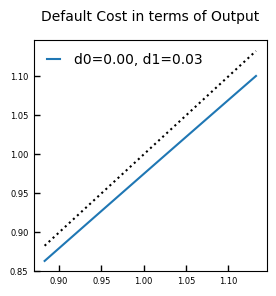

In [81]:
ny=Int32(51); ρ=0.9293f0; σ_ϵ=0.0115f0
grid, P = tauchen_carlo(ny, ρ, σ_ϵ)
ygrid = exp.(grid)

fn=21
figure(fn, figsize=(3,3), dpi=100)
clf()
ds = [
    0.       0.025;
    #-0.1    0.005;
    # -0.2    0.01;
    # -0.3    0.0125;
    # -0.4    0.005;
    # -0.5    0.02;
    ]
for i in 1:size(ds)[1]
    d0 = ds[i,1]
    d1 = -d0+ds[i,2]
    plot(ygrid, [y-max(0, d0*y+d1*y^2) for y in ygrid], label=@sprintf("d0=%.2f, d1=%.2f", d0, d1))
    # plot(model.ygrid, [max(0, d0*y+d1*y^2) for y in model.ygrid], label=@sprintf("d0=%.4f, d1=%.4f", d0, d1))
end
plot(ygrid, ygrid, ":k")
# plot(model.ygrid, zeros(model.ny), ":k")
title("Default Cost in terms of Output")
plot_style(fn)

Figure(PyObject <Figure size 300x300 with 0 Axes>)